# Training an Object Detection model using Azure AutoML for Images - [Kitti](http://www.cvlibs.net/datasets/kitti/) 
In this notebook, we go over how you can use Azure AutoML for Images to train an Object Detection model. We will use the Kitti dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model for use in inference scenarios. For detailed information please refer to the [documentation of AutoML for Images](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models) and this [tutorial](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models). 

## I. Setups

### 1.1 Environment setup
Please follow the ["Setup a new conda environment"](https://github.com/Azure/azureml-examples/tree/main/python-sdk/tutorials/automl-with-azureml#3-setup-a-new-conda-environment) instructions to get started.

### 1.2 Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [ ]:
from azureml.core.workspace import Workspace

# specify workspace parameters
subscription_id='<my-subscription-id>'   
resource_group='<my-resource-group>'   
workspace_name='<my-workspace-name>'

ws = Workspace.create(
    name=workspace_name,
    subscription_id=subscription_id,
    resource_group=resource_group,
    exist_ok=True,
)

### 1.3 Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [ ]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "nc6sv3-cluster"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")
except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6s_v3",
        idle_seconds_before_scaledown=1800,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(
    show_output=True, min_node_count=None, timeout_in_minutes=20
)

### 1.4 Experiment setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [ ]:
from azureml.core import Experiment

experiment_name = "automl-image-object-detection-kitti-runs"
experiment = Experiment(ws, name=experiment_name)

### 1.5 Dataset with input Training Data

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset). You can either use a dataset that you have exported from a [Data Labeling](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-label-data) project, or create a new Tabular Dataset with your labeled training data. We will use the second option in this notebook.

#### Upload the JSONL file and images to Datastore
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data and interact with it from your remote compute targets. It is an abstraction over Azure Storage.

We upload the 'kitti_single' folder that has both the json annotations and training folder of images to the default datastore(Every workspace comes with a blob storage and the default container in it is registered as the default datastore, you can bring in containers from other storage accounts and register them as datastores as explained [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-data).

In [ ]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir="./kitti_single", target_path="kitti_single")

Finally, we need to create an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [ ]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset

training_dataset_name = 'KittiTrainingDataset'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.OBJECT_DETECTION, path=ds.path('kitti_single/train_ignore_tiny.json'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)
    
# create validation dataset
validation_dataset_name = "KittiValidationDataset"
if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print('Found the validation dataset', validation_dataset_name)
else:
    validation_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.OBJECT_DETECTION, path=ds.path('kitti_single/val_ignore_tiny.json'))
    validation_dataset = validation_dataset.register(workspace=ws, name=validation_dataset_name)
    
    
print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-agnostic-hyperparameters) for more details.

This is what the training dataset looks like:

In [6]:
training_dataset.to_pandas_dataframe()

,image_details,label,image_url
0,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Truck', 'topX': 0.4826167471819645...",StreamInfo(AmlDatastore://kitti_single/trainin...
1,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.2257487922705314, ...",StreamInfo(AmlDatastore://kitti_single/trainin...
2,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Pedestrian', 'topX': 0.26574879227...",StreamInfo(AmlDatastore://kitti_single/trainin...
3,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.0, 'topY': 0.51298...",StreamInfo(AmlDatastore://kitti_single/trainin...
4,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.8159339774557166, ...",StreamInfo(AmlDatastore://kitti_single/trainin...
...,...,...,...
5979,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.7532608695652173, ...",StreamInfo(AmlDatastore://kitti_single/trainin...
5980,"{'format': 'png', 'width': '1224px', 'height':...","[{'label': 'Pedestrian', 'topX': 0.18010620915...",StreamInfo(AmlDatastore://kitti_single/trainin...
5981,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.4789694041867955, ...",StreamInfo(AmlDatastore://kitti_single/trainin...
5982,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.45250402576489535,...",StreamInfo(AmlDatastore://kitti_single/trainin...


In [7]:
validation_dataset.to_pandas_dataframe()

,image_details,label,image_url
0,"{'format': 'png', 'width': '1224px', 'height':...","[{'label': 'Pedestrian', 'topX': 0.58202614379...",StreamInfo(AmlDatastore://kitti_single/trainin...
1,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Misc', 'topX': 0.6479790660225443,...",StreamInfo(AmlDatastore://kitti_single/trainin...
2,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.4945571658615137, ...",StreamInfo(AmlDatastore://kitti_single/trainin...
3,"{'format': 'png', 'width': '1238px', 'height':...","[{'label': 'Car', 'topX': 0.44264943457189015,...",StreamInfo(AmlDatastore://kitti_single/trainin...
4,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.45460547504025767,...",StreamInfo(AmlDatastore://kitti_single/trainin...
...,...,...,...
1492,"{'format': 'png', 'width': '1238px', 'height':...","[{'label': 'Pedestrian', 'topX': 0.94318255250...",StreamInfo(AmlDatastore://kitti_single/trainin...
1493,"{'format': 'png', 'width': '1224px', 'height':...","[{'label': 'Van', 'topX': 0.0, 'topY': 0.30497...",StreamInfo(AmlDatastore://kitti_single/trainin...
1494,"{'format': 'png', 'width': '1242px', 'height':...","[{'label': 'Car', 'topX': 0.6244122383252818, ...",StreamInfo(AmlDatastore://kitti_single/trainin...
1495,"{'format': 'png', 'width': '1224px', 'height':...","[{'label': 'Pedestrian', 'topX': 0.43678104575...",StreamInfo(AmlDatastore://kitti_single/trainin...


## II. Model Sweep

### 2.1 Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

### 2.2 Using default hyperparameter values for the specified algorithms

In [ ]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_default = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    hyperparameter_sampling=GridParameterSampling({"model_name": choice("yolov5",
                                                                        "fasterrcnn_resnet50_fpn",
                                                                        "retinanet_resnet50_fpn")}),
    iterations=3
)

### 2.3 Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [ ]:
automl_model_sweep_run = experiment.submit(image_config_default)

In [ ]:
automl_model_sweep_run.wait_for_completion(wait_post_processing=True)

### 2.4 Metrics - Default Model Sweep 

In [99]:
from azureml.train.automl.run import AutoMLRun
import pandas as pd 

automl_run_id = "AutoML_12aa72a1-419e-4a54-9354-8449944af795"
automl_image_run = AutoMLRun(experiment=experiment, run_id=automl_run_id)
best_run_child = automl_image_run.get_best_child()
for hd_run in automl_image_run.get_children():
    metrics_dict_default = hd_run.get_metrics()
    
run_details_list = list()
for key, value in hp_dict_default.items(): 
    run_details = dict()
    run_details['model_name'] = eval(value)['model_name']
    run_details['run_id'] = key
    run_details_list.append(run_details)
    
run_metrics_list = list()
for key, value in metrics_dict_default.items(): 
    map_dict = dict()
    map_dict["mAP_best"] = max(value['mean_average_precision'])
    map_dict["mAP_epochs"] = value['mean_average_precision']
    map_dict['run_id'] = key
    run_metrics_list.append(map_dict)

run_details_df = pd.DataFrame(run_details_list)
run_metrics_df = pd.DataFrame(run_metrics_list)
merged_df = pd.merge(run_details_df, run_metrics_df, on='run_id', how='inner')
default_runs_leaderboard = merged_df.sort_values(by='mAP_best', ascending=False)
default_runs_leaderboard.head(20)

,model_name,run_id,mAP_best,mAP_epochs
0,yolov5,AutoML_12aa72a1-419e-4a54-9354-8449944af795_HD_0,0.92209,"[0.33075, 0.54905, 0.66619, 0.73602, 0.78323, ..."
1,fasterrcnn_resnet50_fpn,AutoML_12aa72a1-419e-4a54-9354-8449944af795_HD_1,0.91178,"[0.61692, 0.6901, 0.79289, 0.81653, 0.83978, 0..."
2,retinanet_resnet50_fpn,AutoML_12aa72a1-419e-4a54-9354-8449944af795_HD_2,0.86770,"[0.43516, 0.47845, 0.62235, 0.60634, 0.75461, ..."


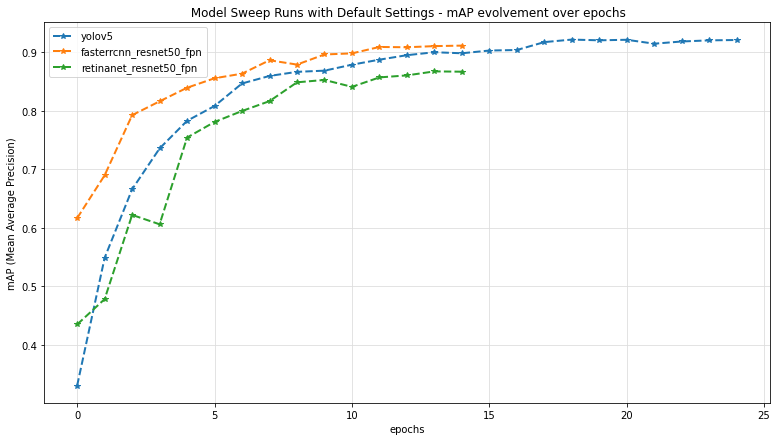

In [143]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(13, 7))
  
plt.plot(list( default_runs_leaderboard[default_runs_leaderboard['model_name']=='yolov5']['mAP_epochs'])[0], label = 'yolov5',  marker='*', linestyle='--', linewidth=2)
plt.plot(list(default_runs_leaderboard[default_runs_leaderboard['model_name']=='fasterrcnn_resnet50_fpn']['mAP_epochs'])[0], label = 'fasterrcnn_resnet50_fpn',  marker='*', linestyle='--', linewidth=2)  
plt.plot(list(default_runs_leaderboard[default_runs_leaderboard['model_name']=='retinanet_resnet50_fpn']['mAP_epochs'])[0], label = 'retinanet_resnet50_fpn',  marker='*', linestyle='--', linewidth=2)

plt.xlabel("epochs")
plt.ylabel("mAP (Mean Average Precision)")
plt.title(' Model Sweep Runs with Default Settings - mAP evolvement over epochs')
plt.grid( color='#DDDDDD', linewidth = 0.8)
plt.legend()
plt.show()

## III. Hyperparameter sweeping for your AutoML models for computer vision tasks

### 3.1 Hyperparamters Setups

In this example, we use the AutoMLImageConfig to train an Object Detection model using `yolov5` and `fasterrcnn_resnet50_fpn`, both of which are pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label categories.

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find an optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for different hyperparameters to generate a model with the optimal primary metric. If hyperparameter values are not specified, then default values are used for the specified algorithm. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the full list of supported algorithms, hyperparameters and their default values.

We use Random Sampling to pick samples from this parameter space and try a total of 16 iterations with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [ ]:
from azureml.train.automl import AutoMLImageConfig
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    
    'model': choice(
        {
            'number_of_epochs': 30,
            'model_name': choice('yolov5'),
            'learning_rate': choice(0.001, 0.005, 0.01),
            'grad_accumulation_step': choice(1, 2),
            'training_batch_size': 8,
            'validation_batch_size': 8,
            'img_size': choice(640, 960)
        },
        {
            'number_of_epochs': 30,
            'model_name': choice('fasterrcnn_resnet50_fpn'),
            'learning_rate': choice(0.0001, 0.001, 0.005),
            'min_size': choice(600, 800),
        }
    )
}

tuning_settings = {
    'iterations': 18,
    'max_concurrent_iterations': 6,
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),
    'policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=15)
}

automl_tuning_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

In [ ]:
automl_tuning_run = experiment.submit(automl_tuning_config)

In [ ]:
automl_tuning_run.wait_for_completion(wait_post_processing=True)

When doing a hyperparameter sweep, it can be useful to visualize the different configurations that were tried using the HyperDrive UI. You can navigate to this UI by going to the 'Child runs' tab in the UI of the main `automl_image_run` from above, which is the HyperDrive parent run. Then you can go into the 'Child runs' tab of this HyperDrive parent run. 

### 3.2 Leaderboard - Hyperparameter Tuning Runs

In [157]:
from azureml.train.automl.run import AutoMLRun
import pandas as pd

automl_run_id = "AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a"
automl_image_run = AutoMLRun(experiment=experiment, run_id=automl_run_id)
best_run_child = automl_image_run.get_best_child()
for hd_run in automl_image_run.get_children():
    hp_dict = hd_run.get_hyperparameters()
    metrics_dict = hd_run.get_metrics()
    
run_details_list = list()
for key, value in hp_dict.items(): 
    run_details = eval(value)['model']
    run_details['run_id'] = key
    run_details_list.append(run_details)
    
run_metrics_list = list()
for key, value in metrics_dict.items(): 
    map_dict = dict()
    map_dict["mean_average_precision"] = max(value['mean_average_precision'])
    map_dict['run_id'] = key
    run_metrics_list.append(map_dict)
    
run_details_df = pd.DataFrame(run_details_list)
run_metrics_df = pd.DataFrame(run_metrics_list)

merged_df = pd.merge(run_details_df, run_metrics_df, on='run_id', how='inner')
merged_df = merged_df.fillna('')

leader_board_df = merged_df.sort_values(by='mean_average_precision', ascending=False)
leader_board_df.head(20)

,learning_rate,min_size,model_name,run_id,grad_accumulation_step,img_size,training_batch_size,validation_batch_size,mean_average_precision
6,0.0050,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_6,1,960,8,8,0.93899
3,0.0100,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_3,1,960,8,8,0.93449
9,0.0100,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_9,2,960,8,8,0.93349
10,0.0100,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_10,2,640,8,8,0.92956
17,0.0100,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_17,1,640,8,8,0.92731
15,0.0050,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_15,2,960,8,8,0.92570
2,0.0050,800,fasterrcnn_resnet50_fpn,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_2,,,,,0.91972
12,0.0050,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_12,1,640,8,8,0.91933
11,0.0050,600,fasterrcnn_resnet50_fpn,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_11,,,,,0.91434
14,0.0050,,yolov5,AutoML_3a81d22a-b37d-4b76-903c-f8625e06762a_HD_14,2,640,8,8,0.90732


In [ ]:
leader_board_df.to_csv('leaderboard.csv', index = False)

## IV. Deploy the Model

### 4.1 Register the optimal vision model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [ ]:
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties["model_name"]
model = best_child_run.register_model(
    model_name=model_name, model_path="outputs/model.pt"
)

### 4.2 Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). Please note that ACI only supports small models under 1 GB in size. For testing larger models or for the high-scale production stage, we recommend using AKS.
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [ ]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-gpu-cluster"
# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target")
except ComputeTargetException:
    print("Creating a new compute target...")
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(
        vm_size="STANDARD_NC6", location="eastus2"
    )
    # Create the cluster
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)

Next, you will need to define the [inference configuration](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#update-inference-configuration), that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [ ]:
from azureml.core.model import InferenceConfig

best_child_run.download_file(
    "outputs/scoring_file_v_1_0_0.py", output_file_path="score.py"
)
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script="score.py", environment=environment)

You can then deploy the model as an AKS web service.

In [ ]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

aks_config = AksWebservice.deploy_configuration(
    autoscale_enabled=True, cpu_cores=1, memory_gb=20, enable_app_insights=True
)

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name="automl-kitti-test",
    overwrite=True,
)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

## Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to the scoring URI.

In [155]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri

# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()

sample_image = "./test_image.png"

# Load image data
data = open(sample_image, "rb").read()

# Set the content type
headers = {"Content-Type": "application/octet-stream"}

# If authentication is enabled, set the authorization header
headers["Authorization"] = f"Bearer {key}"

# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmppnkr8eej", "boxes": [{"box": {"topX": 0.06048886775970459, "topY": 0.5330407165738538, "bottomX": 0.16050888697306315, "bottomY": 0.6711689774140355}, "label": "Car", "score": 0.9456223845481873}, {"box": {"topX": 0.1492457389831543, "topY": 0.5190075937026924, "bottomX": 0.21771275202433268, "bottomY": 0.6274487980509299}, "label": "Car", "score": 0.9411697387695312}, {"box": {"topX": 0.40195099512736004, "topY": 0.4744124363037954, "bottomX": 0.46548763910929364, "bottomY": 0.6256783561310554}, "label": "Car", "score": 0.9282779693603516}, {"box": {"topX": 0.31099230448404946, "topY": 0.4937579409061419, "bottomX": 0.34320907592773436, "bottomY": 0.5606444467722751}, "label": "Car", "score": 0.9230316877365112}, {"box": {"topX": 0.4654100735982259, "topY": 0.4540190911210532, "bottomX": 0.4948410987854004, "bottomY": 0.5460742567649762}, "label": "Car", "score": 0.9214379191398621}, {"box": {"topX": 0.742962137858073, "topY": 0.4180542836964749, "bottomX": 0.976

## Visualize detections
Now that we have scored a test image, we can visualize the bounding boxes for this image

Car: [75.127, 199.89, 124.225, 51.798], 0.946
Car: [185.363, 194.628, 85.036, 40.665], 0.941
Car: [499.223, 177.905, 78.913, 56.725], 0.928
Car: [386.252, 185.159, 40.013, 25.082], 0.923
Car: [578.039, 170.257, 36.553, 34.521], 0.921
Car: [922.759, 156.77, 289.788, 89.162], 0.916
Car: [705.5, 166.487, 44.451, 29.903], 0.895
Car: [0.0, 190.198, 89.087, 105.355], 0.89
Car: [1151.382, 160.453, 90.397, 139.933], 0.873


<Figure size 1296x864 with 0 Axes>

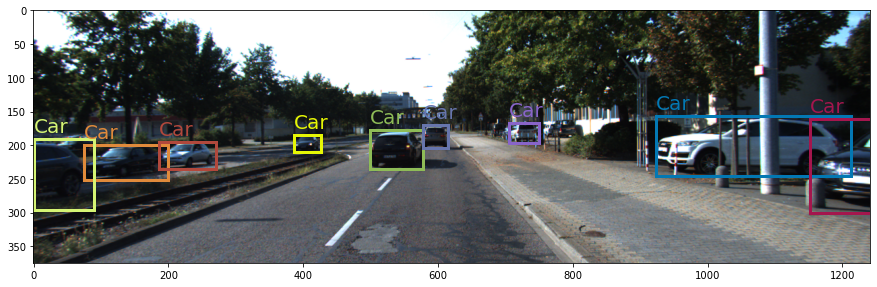

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18, 12)
plt.figure(figsize=IMAGE_SIZE)
img_np = mpimg.imread(sample_image)
img = Image.fromarray(img_np.astype("uint8"), "RGB")
x, y = img.size

fig, ax = plt.subplots(1, figsize=(15, 15))
# Display the image
ax.imshow(img_np)

# draw box and label for each detection
detections = json.loads(resp.text)
for detect in detections["boxes"]:
    label = detect["label"]
    box = detect["box"]
    conf_score = detect["score"]
    if conf_score > 0.6:
        ymin, xmin, ymax, xmax = (
            box["topY"],
            box["topX"],
            box["bottomY"],
            box["bottomX"],
        )
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print(
            "{}: [{}, {}, {}, {}], {}".format(
                detect["label"],
                round(topleft_x, 3),
                round(topleft_y, 3),
                round(width, 3),
                round(height, 3),
                round(conf_score, 3),
            )
        )

        color = np.random.rand(3)  #'red'
        rect = patches.Rectangle(
            (topleft_x, topleft_y),
            width,
            height,
            linewidth=3,
            edgecolor=color,
            facecolor="none",
        )

        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, label, color=color, fontsize=20)
plt.show()